# Tutorial Computational Graphs

In this exercise you will implement a computational graph in python.

In [1]:
import numpy as np
import graphviz as gz
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
class Gate:
    
    """
        Every gate has a set of inputs (input_nodes) and consumers.
        Additionally a gate has to implement the methods forward and backward.
        The forward method computes the result with respect to the given input nodes 
        (use the out field) of the input gates and stores the value in the field out.
        The backward function computes and propagates the gradient for the given gate.
        On call of the backward function, the gate uses the incoming gradient dz and adds 
        to all input nodes the corresponding gradient.
    """
    
    name = "???"

    def __init__(self, input_nodes=[], name=None):
        self.out = None
        self.dz = 0
        self.dzs = {}
        
        if name is not None:
            self.name = name

        # Store the address of input_nodes so the current gate can access
        # the value from the input_nodes during forward propagation
        self.input_nodes = input_nodes

        self.consumers = []

        # Register the current gate as a consumer of each input node, so
        # it can know which input gates to propagate during backpropagation
        for input_node in input_nodes:
            input_node.consumers.append(self)

    def forward(self):
        """Computes the output of this operation.
        "" Must be implemented by the particular operation.
        """
        pass

    def backward(self):
        """
        "" Must be implemented by the particular operation.
        """
        pass

    # gate: consumer of the current node (gate)
    # dz: the local gradient of the consumer gate with the current node
    def put_gradient(self, gate, dz):
        # make sure consumer gate is registered as the comsumers of the current node
        if gate in self.consumers:
            # multiply the local gradient of the consumer gate with the current node
            # and the accumulated gradient of the consumer gate
            self.dz += dz * gate.dz
            self.dzs[gate] = dz

In [3]:
class ComputationalGraph:
    
    """
        This class implements the backward and forward function for the whole graph.
        Both methods return a graphviz object visualizing the respective steps.
        To draw the computational graphs in jupyter notebook you can for instance use the imported display function.
    """
    
    def __init__(self, target):
        def get_nodes(target, nodes=[]):
            if target in nodes:
                nodes.remove(target)
            nodes.append(target)
            for inp in target.input_nodes:
                get_nodes(inp, nodes)
            return nodes
        self.nodes = list(reversed(get_nodes(target)))
    
    def forward(self, inputs):
        g = gz.Digraph('G', strict=True)
        g.graph_attr['rankdir'] = 'LR'
        for gate in self.nodes:
            if gate in inputs:
                gate.value = inputs[gate]
            gate.forward()
            g.node(str(id(gate)), label="<%s<br/><FONT POINT-SIZE='10'>%.3f</FONT>>" % (gate.name, gate.out))
            for node in gate.consumers:
                g.edge(str(id(gate)), str(id(node)))
        return g
    
    def backward(self):
        g = gz.Digraph('G', strict=True)
        g.graph_attr['rankdir'] = 'RL'
        for gate in self.nodes: gate.dz = 0
        self.nodes[-1].dz = 1
        for gate in reversed(self.nodes):
            gate.backward()
            g.node(str(id(gate)), label="<%s<br/><FONT POINT-SIZE='10'>%.3f</FONT>>" % (gate.name, gate.dz))
            for node in gate.input_nodes:
                g.edge(str(id(gate)), str(id(node)), label="%.3f" % node.dzs[gate])
        return g

* Example: Add Gate

In [4]:
class AddGate(Gate):
    
    name = "+"
    _
    def __init__(self, inputs, name=None):
        super().__init__(inputs, name)
    
    def forward(self):
        self.input_values = [n.out for n in self.input_nodes]
        self.out = np.sum(self.input_values)
    
    def backward(self):
        for i, node in enumerate(self.input_nodes):
            node.put_gradient(self, 1)

* Example: Input Gate

In [5]:
class InputGate(Gate):
    
    name = "inp"
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.value = 0
 
    def forward(self):
        self.out = self.value
    
    def backward(self):
        pass # There are no input nodes => nothing to do

* Implement a gate that represents a weight. The constructor shall take the parameter $\alpha$ that represents the learning rate of this weight.

In [6]:
class WeightGate(Gate):
    
    name = "w"
    
    def __init__(self, alpha=0.1, name=None, weight=None):
        super().__init__(name=name)
        self.weight = 2*np.random.random()-1 if weight is None else weight
        self.alpha = alpha
    
    def forward(self):
        self.out = self.weight
    
    def backward(self):
        self.weight -= self.alpha * self.dz

* Implement a gate that multiplies the outputs of a set of input gates.

In [7]:
class MultiplyGate(Gate):
    
    name = "*"
    _
    def __init__(self, inputs, name=None):
        super().__init__(inputs, name)
    
    def forward(self):
        self.input_values = [n.out for n in self.input_nodes]
        self.out = np.prod(self.input_values)
    
    def backward(self):
        for node in self.input_nodes:
            vals = [n.out for n in self.input_nodes if n != node]
            node.put_gradient(self, np.prod(vals))

* Implement a sigmoid gate that computes the sigmoid of one input.

In [8]:
class SigmoidGate(Gate):
    
    name = "sig"
    _
    def __init__(self, inp1, name=None):
        super().__init__([inp1], name)
    
    def forward(self):
        self.out = 1. / ( 1. + np.exp(-self.input_nodes[0].out) )
    
    def backward(self):
        self.input_nodes[0].put_gradient(self, self.out * (1 - self.out))

* Implement a gate with the following loss function $L(y, \hat{y}) = (\hat{y} - y)^2$.

In [9]:
class SquaredLossGate(Gate):
    
    name = "MSE"
    
    def __init__(self, y, y_pred, name=None):
        super().__init__([y, y_pred], name=name)
    
    def forward(self):
        y, y_pred = [n.out for n in self.input_nodes]
        self.out = (y - y_pred)**2
    
    def backward(self):
        dy = 2 * (self.input_nodes[0].out - self.input_nodes[1].out)
        dy_pred = 2 * (self.input_nodes[1].out - self.input_nodes[0].out)
        self.input_nodes[0].put_gradient(self, dy)
        self.input_nodes[1].put_gradient(self, dy_pred)

* Build the computational graph from exercise 3-3 in python and compute display the computational graph after forward and backward. 

In [10]:
x1 = InputGate('x1')
x2 = InputGate('x2')
y = InputGate('y')

w1 = WeightGate(name='w1', weight=4./5.)
w2 = WeightGate(name='w2', weight=-7./5.)
p0 = WeightGate(name='p0', weight=3./5.)

p1 = MultiplyGate([x1, w1], 'p1')
p2 = MultiplyGate([x2, w2], 'p2')

z = AddGate([p0, p1, p2], 'z')

y_pred = SigmoidGate(z, 'ŷ')

loss = SquaredLossGate(y, y_pred, 'L')

In [11]:
graph = ComputationalGraph(loss)

Forward:



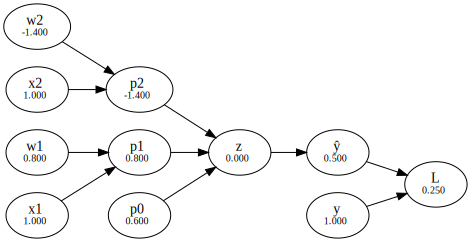

Backward:



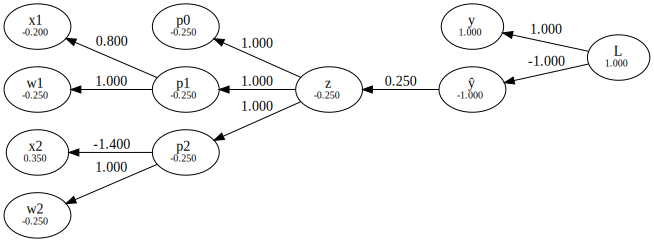

In [12]:
print("Forward:\n")
g = graph.forward({x1: 1, x2: 1, y: 1})
display(g)

print('Backward:\n')
g = graph.backward()
display(g)

* Construct and train a computational graph / network that can classify the XOR dataset with stochastic gradient descent and the already implemented squared loss function.

In [13]:
## XOR
X = [[0,0],[0,1],[1,0],[1,1]]
Y = [0, 1, 1, 0]

In [14]:
def train(graph, epochs):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x_in, y_in in zip(X, Y):
            g = graph.forward({x1: x_in[0], x2: x_in[1], y: y_in})
            epoch_loss += loss.out
            if epoch == epochs-1:
                display(g)
            g = graph.backward()
            if epoch == epochs-1:
                display(g)
        losses.append(epoch_loss/len(Y))
    plt.plot(losses)
    
    plt.show()

Kernel Trick:

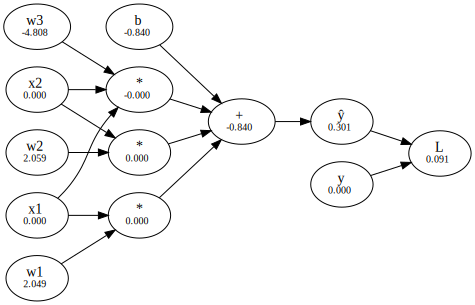

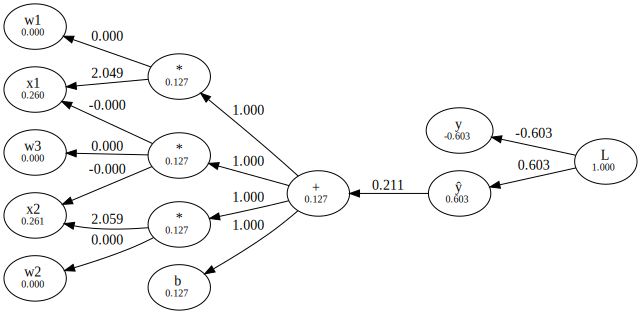

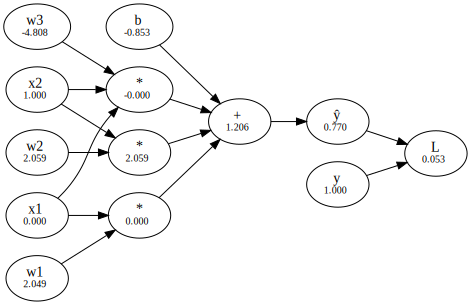

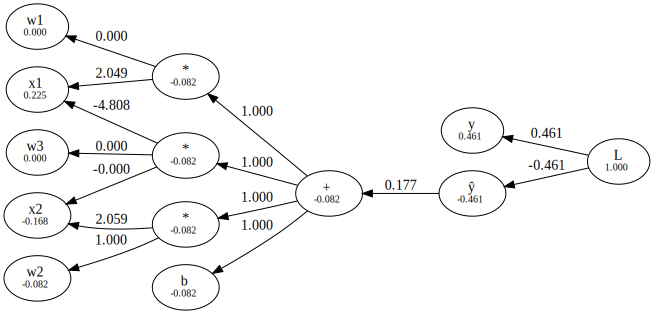

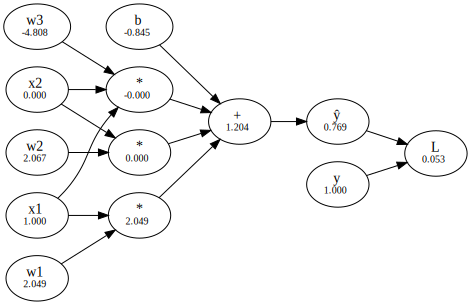

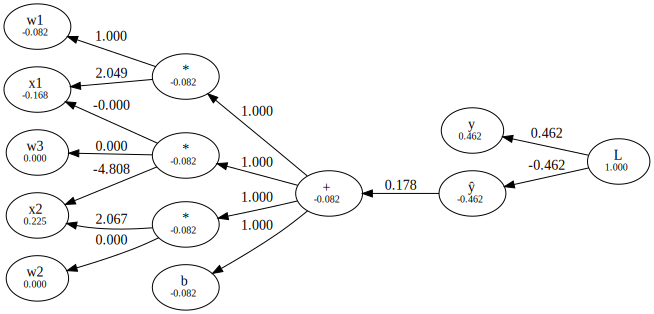

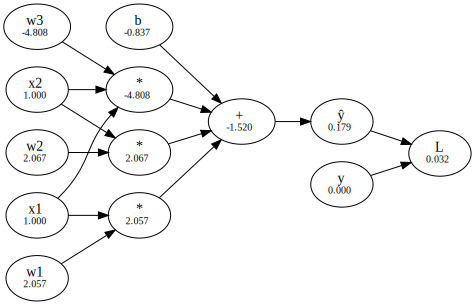

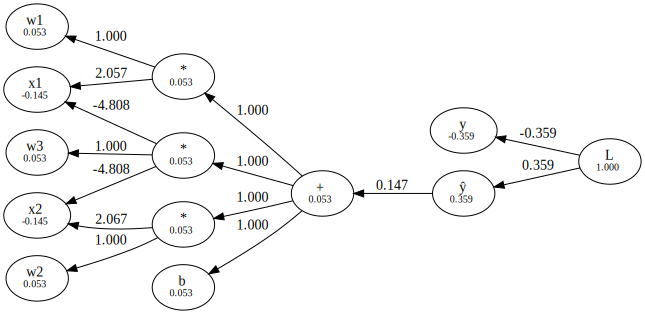

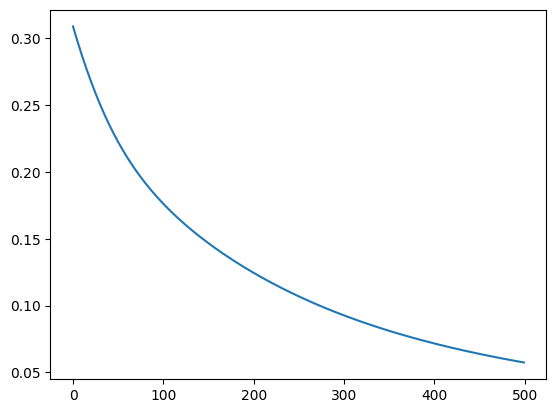

In [15]:
x1 = InputGate('x1')
x2 = InputGate('x2')
y = InputGate('y')

w1 = WeightGate(name='w1', weight=4./5.)
w2 = WeightGate(name='w2', weight=-7./5.)
p0 = WeightGate(name='p0', weight=3./5.)

p1 = MultiplyGate([x1, WeightGate(name='w1')])
p2 = MultiplyGate([x2, WeightGate(name='w2')])
p3 = MultiplyGate([x1, x2, WeightGate(name='w3')])

y_pred = SigmoidGate(AddGate([p1, p2, p3, WeightGate(name='b')]), name='ŷ')
loss = SquaredLossGate(y, y_pred, 'L')

train(ComputationalGraph(loss), 500)

Multi-Layer-Perceptron:

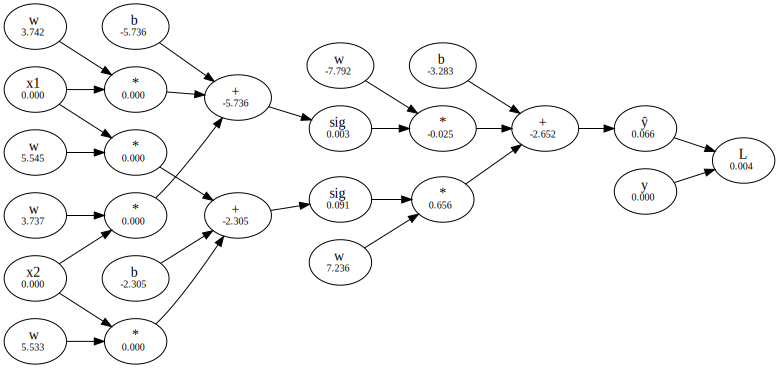

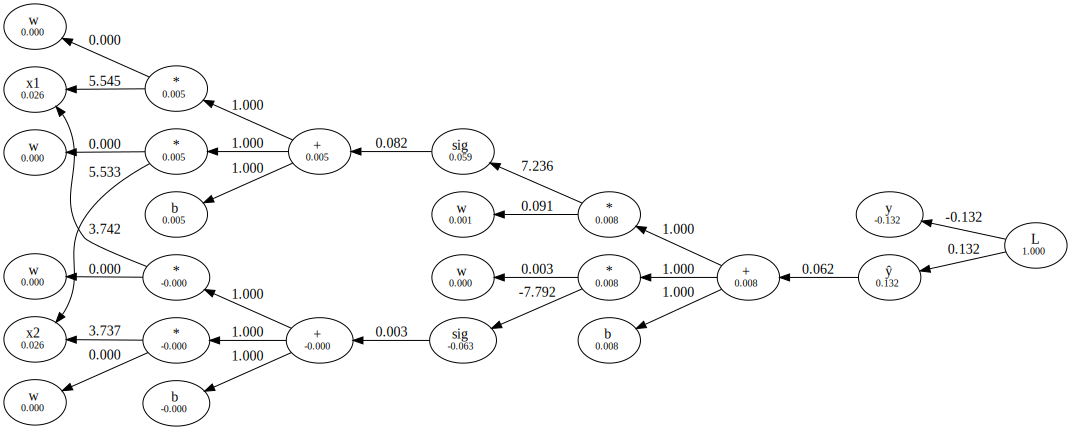

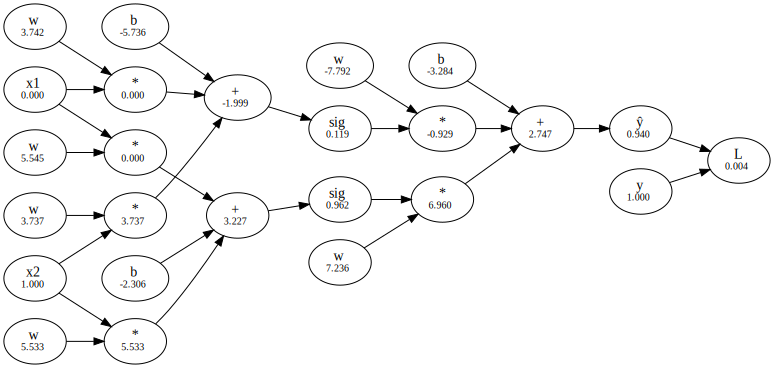

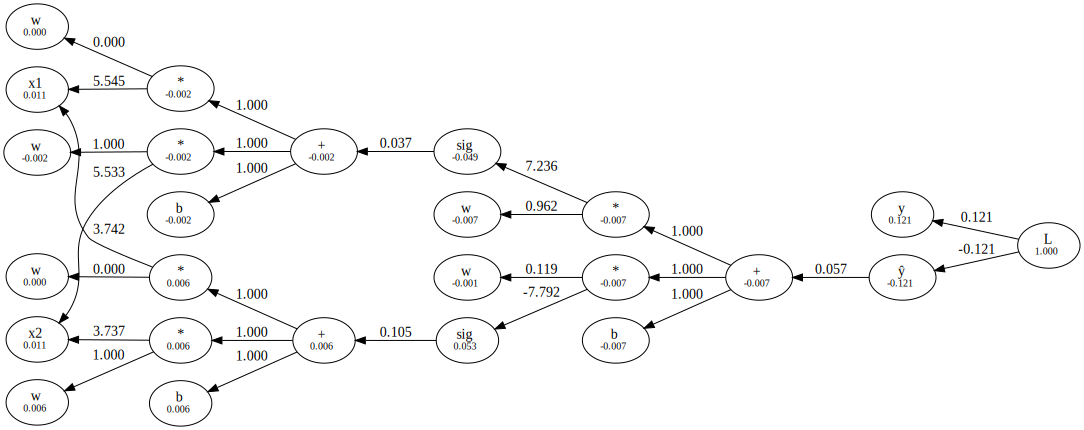

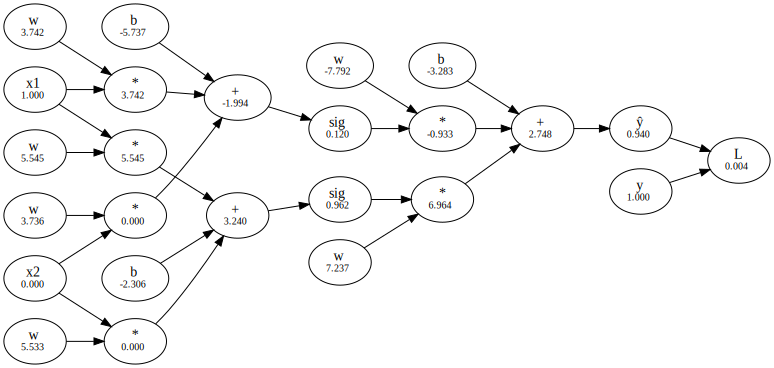

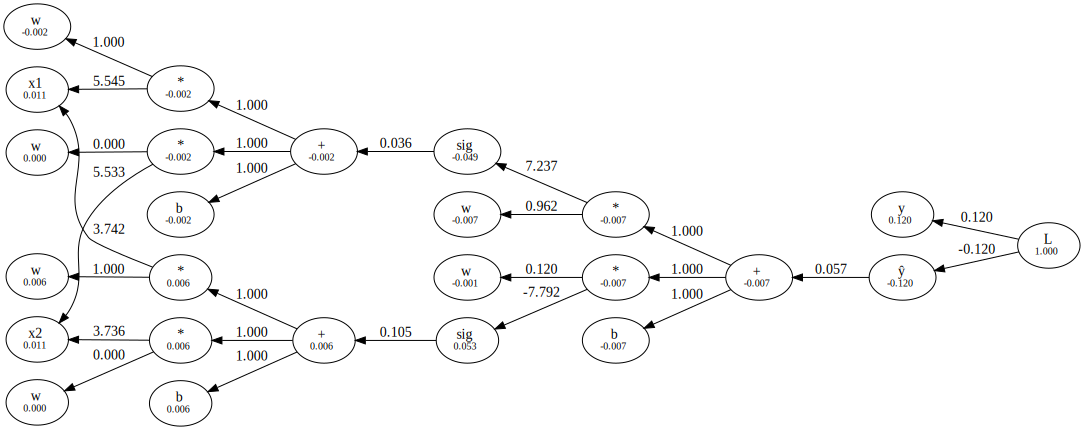

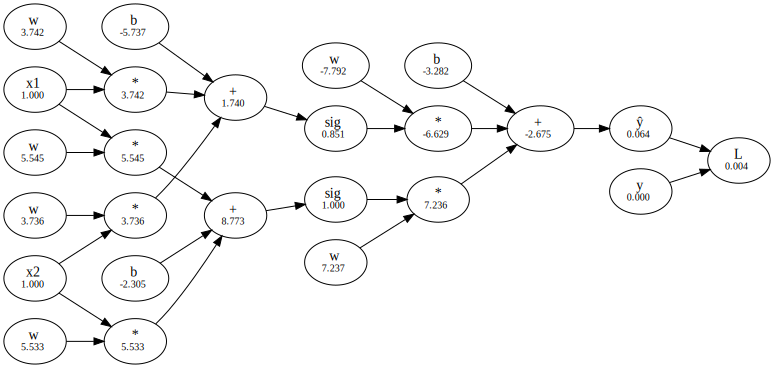

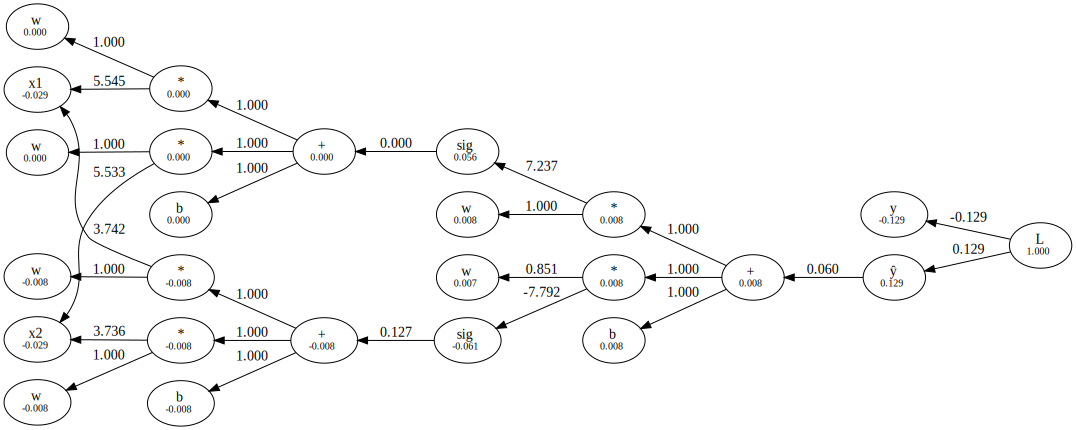

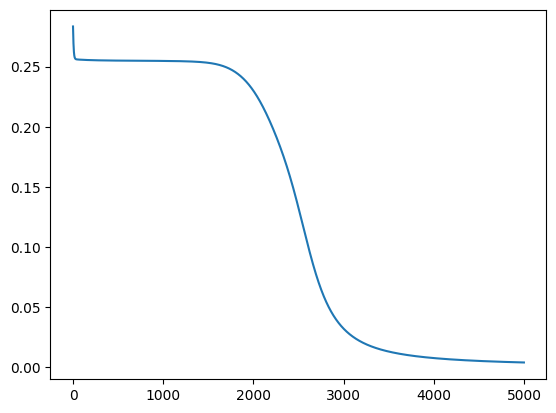

In [16]:
def perceptron(inputs):
    p = [MultiplyGate([inp, WeightGate()]) for inp in inputs]
    p.append(WeightGate(name='b'))
    return AddGate(p)

x1 = InputGate('x1')
x2 = InputGate('x2')
y = InputGate('y')

hidden = [SigmoidGate(perceptron([x1, x2])) for _ in range(2)]
y_pred = SigmoidGate(perceptron(hidden), 'ŷ')

loss = SquaredLossGate(y, y_pred, 'L')

graph = ComputationalGraph(loss)

epochs = 5000

train(graph, epochs)

Question: Why do we need so many epochs with the multi-layer percetpron?
* Gradient of the sigmoid activation functions is very small and it takes a lot of epochs until the gradient increases. After that it converges much faster.

Question: How can this be improved?
* Using Cross-Entropy-Loss with Softmax
* Do not use Softmax activation functions at hidden layers
* Batch-Gradient-Decsent
* ...